In [2]:
import numpy as np
import scipy.stats as sps

Генератор распределения Фреше.

In [3]:
def frechet_sample(gamma, size):
    U = np.random.uniform(size=size)
    return (-np.log(U))**(-gamma) / gamma

Оценка Хилла.

In [4]:
def hill_estimator(sample: np.ndarray) -> np.ndarray:
    '''
    Calculate Hill's estimates for k = 1, ..., (number of positive observations) - 1
    '''
    data = sample[sample > 0]
    if np.all(data[:-1] >= data[1:]):
        log_data = np.log(data)
    else:
        log_data = np.log(np.sort(data)[::-1])

    return np.cumsum(log_data)[:-1] / np.arange(1, len(log_data)) - log_data[1:]

Оценка mixed moment.

In [5]:
def mixed_moment_estimator(sample: np.ndarray,
                           hill_estims: np.ndarray | None = None) -> np.ndarray:
    '''
    Calculate mixed moment estimates for k = 1, ..., (number of positive observations) - 1
    :param hill_estims: Hill's estimates of EVI
    '''
    data = sample[sample > 0]
    if not np.all(data[:-1] >= data[1:]):
        data = np.sort(data)[::-1]

    if hill_estims is None:
        hill_estims = hill_estimator(data)

    L = 1 - np.cumsum(1 / data)[:-1] * data[1:] / np.arange(1, len(data))
    phi = (hill_estims - L) / L**2
    estims = (phi - 1) / (1 + 2 * np.min(phi - 1, 0))

    return estims

Оценка Generalised Jackknife.

$$ \hat{\gamma}_k^{GJ} = 2\hat{\gamma}_k^V - \hat{\gamma}^H(n, k) $$

$$ \hat{\gamma}_k^V = \frac{M_{nk}}{2\hat{\gamma}^H(n, k)} $$

$$ M_{nk} = \frac{1}{k} \sum_{i=1}^k Y_{(i, k)}^2 $$

$$ Y_{(i, k)} = \ln \frac{X_{(n - i + 1)}}{X_{(n - k)}} $$

In [6]:
def generalised_jackknife_estimator(sample: np.ndarray,
                                    hill_estims: np.ndarray | None = None) -> np.ndarray:
    '''
    Calculate Generalised Jackknife estimates for k = 1, ..., (number of positive observations) - 1
    :param hill_estims: Hill's estimates of EVI
    '''
    data = sample[sample > 0]
    if not np.all(data[:-1] >= data[1:]):
        data = np.sort(data)[::-1]
    log_data = np.log(data)

    if hill_estims is None:
        hill_estims = hill_estimator(data)

    nums = np.arange(1, len(log_data))
    sums = np.cumsum(log_data)[:-1]
    sums2 = np.cumsum(log_data**2)[:-1]

    M = (sums2 - 2 * sums * log_data[1:] + log_data[1:]**2 * nums) / nums

    return M / hill_estims - hill_estims

Метод Eye-Ball.

In [7]:
def eye_ball_tail_size(estimates: np.ndarray, w_proportion: float = 0.01,
                       h: float = 0.9, eps: float = 0.3) -> int:
    '''
    Eye-Ball selection of k for tail index estimation
    :param estimates: tail index estimates for different k
    '''
    w = int(len(estimates) * w_proportion)

    for k in range(1, len(estimates) - w):
        diffs = estimates[k + 1:k + w + 1] - estimates[k]
        if np.sum((diffs > -eps) & (diffs < eps)) / w > h:
            return k + 1

Проверяем.

In [150]:
b = 1
N = 10000

sample = sps.pareto.rvs(b=b, size=N)

In [178]:
gamma_estims = mixed_moment_estimator(sample)
alpha_estims = 1 / gamma_estims

In [179]:
k_eye = eye_ball_k(alpha_estims, h=0.95)
k_eye

13

In [180]:
print(f'alpha estimate: {alpha_estims[k_eye - 1]}')

alpha estimate: 0.43057519184839294


In [521]:
import matplotlib.pyplot as plt

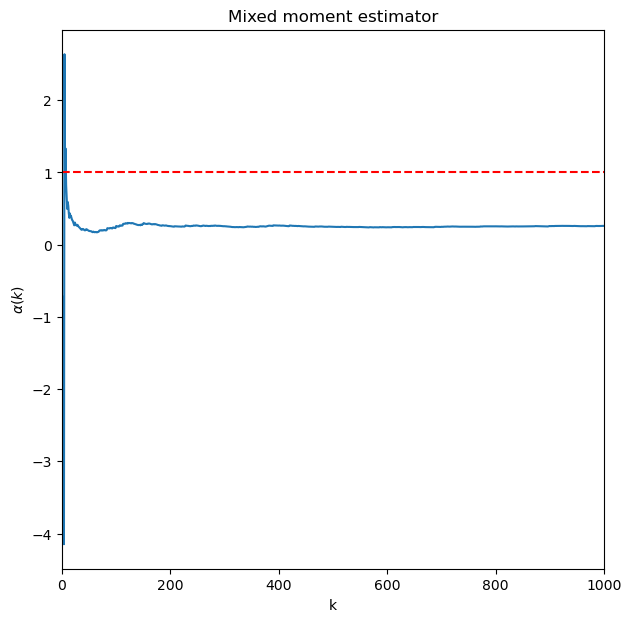

In [182]:
plt.figure(figsize=(7, 7))

plt.plot(np.arange(1, len(alpha_estims) + 1), alpha_estims)
plt.axhline(y=b, color='red', linestyle = '--')

plt.title('Mixed moment estimator')
plt.xlabel('k')
plt.ylabel('$\\alpha(k)$')

plt.xlim((0, 1000))

plt.show()

In [256]:
b = 1
N = 10000

sample = sps.pareto.rvs(b=b, size=N)

In [257]:
gj_gamma = generalised_jackknife_estimator(sample)
gj_alpha = 1 / gj_gamma
k_eye = eye_ball_tail_size(gj_alpha)

In [258]:
k_eye

3

In [259]:
print(f'alpha estimate: {gj_alpha[k_eye - 1]}')

alpha estimate: 1.2402573033743025


In [260]:
gj_alpha[1:].mean()

1.049290289131547

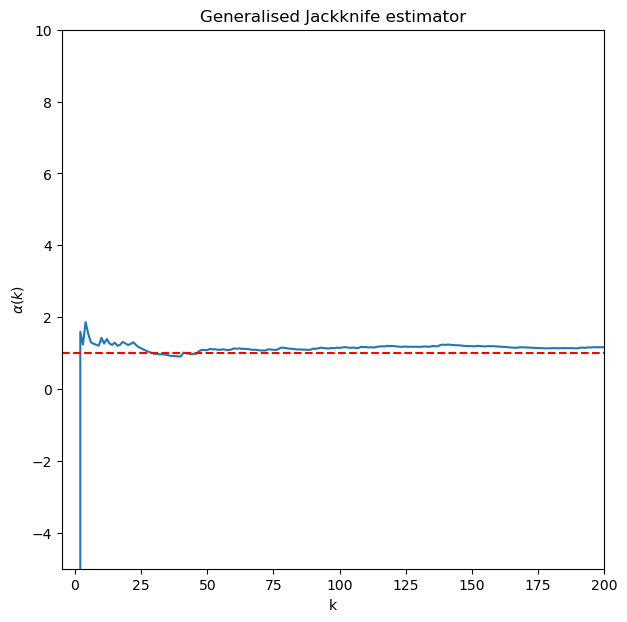

In [261]:
plt.figure(figsize=(7, 7))

plt.plot(np.arange(1, len(gj_alpha) + 1), gj_alpha)
plt.axhline(y=1, color='red', linestyle = '--')

plt.title('Generalised Jackknife estimator')
plt.xlabel('k')
plt.ylabel('$\\alpha(k)$')

plt.xlim((-5, 200))
plt.ylim((-5, 10))

plt.show()

SAMSEE:

$$ \hat{k}_{SAMSEE} = \arg\min_{1 < k < K^*} SAMSEE(k) $$

$$ SAMSEE(k) = \frac{(\hat{\gamma}_{K^*}^{GJ})^2}{k} + 4 \hat{b}_{k, K^*}^2, \ \hat{b}_{k, K} = \overline{\gamma}_{k, K} - \overline{\gamma}_K $$

$$ \overline{\gamma}_{k, K} = \frac{1}{K - k + 1} \sum_{i=k}^K \hat{\gamma}^H(n, i), \ \overline{\gamma}_K = \frac{1}{K} \sum_{i=1}^K \hat{\gamma}^H(n, i) $$

Выбор $K^*$:

$$
AD(K) = \frac{1}{K} \sum_{k=1}^K \left( \hat{\gamma}_k^V + \hat{b}_{k, K} - \hat{\gamma}^H(n, k) \right)^2
$$

$$ K^* = \arg \min_K \left\{ \sum_{i=-2, i \ne 0}^2 \left| \frac{AD(K) - AD(K + i)}{i} \right| \right\} $$

$$
\hat{\gamma}_k^V = (\hat{\gamma}_k^{GJ} + \hat{\gamma}^H(n, k)) / 2
$$

In [1]:
def samsee(sample: np.ndarray,
           hill_estims: np.ndarray | None = None,
           gj_estims: np.ndarray | None = None) -> np.ndarray:
    '''
    Calculates SAMSEE(k) for k = 1, ..., K*
    :param hill_estims: Hill's estimates of EVI
    :param gj_estims: Generalised Jackknife estimates of EVI
    '''
    data = sample[sample > 0]
    if not np.all(data[:-1] >= data[1:]):
        data = np.sort(data)[::-1]
    log_data = np.log(data)

    if hill_estims is None:
        hill_estims = hill_estimator(data)

    if gj_estims is None:
        gj_estims = generalised_jackknife_estimator(data, hill_estims)

    gamma_V = (gj_estims + hill_estims) / 2

    hill_prefs = np.concatenate([[0], np.cumsum(hill_estims)])
    b = lambda k, K: (hill_prefs[K] - hill_prefs[k - 1]) / (K - k + 1) - hill_prefs[K] / K

    N = min(len(data), 4 * int(len(data)**0.5))

    AD = np.zeros(N)
    for K in range(1, N):
        b_arr = np.array([b(k, K) for k in range(1, K + 1)])
        AD[K] = ((gamma_V[:K] + b_arr - hill_estims[:K])**2).sum() / K

    deriv = lambda K, i: np.abs((AD[K] - AD[K + i]) / i)
    func = lambda K: deriv(K, -2) + deriv(K, -1) + deriv(K, 1) + deriv(K, 2)
    
    max_K = 3
    for K in range(3, N - 3):
        if func(K) < func(max_K):
            max_K = K

    grid = np.arange(max_K) + 1
    b_arr = np.array([b(k, max_K) for k in grid])

    return gj_estims[max_K - 1]**2 / grid + 4 * b_arr**2


def samsee_tail_size(sample: np.ndarray,
                     hill_estims: np.ndarray | None = None,
                     gj_estims: np.ndarray | None = None) -> int:
    '''
    Calculates k_{SAMSEE} for Generalised Jackknife estimator
    :param hill_estims: Hill's estimates of EVI
    :param gj_estims: Generalised Jackknife estimates of EVI
    '''
    return np.argmin(samsee(sample, hill_estims, gj_estims)) + 1

NameError: name 'np' is not defined

Тест Phillips-Loretan:

$$
H_0: \alpha_1 = \alpha_2 = \alpha
$$

$$
S = \frac{k_1^* (\hat{\alpha}_1 / \hat{\alpha}_2 - 1)^2}{(\hat{\alpha}_1 / \hat{\alpha}_2)^2 + (k_1^* / k_2^*)}
$$

$$
H_0 \Rightarrow S \xrightarrow[]{d} \chi_1^2
$$

In [2]:
def phillips_loretan_pvalue(alpha1: float, k1: float, alpha2: float, k2: float) -> float:
    '''
    Calculates Phillips-Loretan test pvalue
    '''
    stat = k1 * (alpha1 / alpha2 - 1)**2 / ((alpha1 / alpha2)**2 + (k1 / k2)**2)
    return sps.chi2.sf(x=stat, df=1)

In [171]:
sample1 = frechet_sample(size=10000, gamma=1)
sample2 = frechet_sample(size=10000, gamma=2)

In [172]:
hill_gamma1 = hill_estimator(sample1)
gj_gamma1 = generalised_jackknife_estimator(sample1, hill_gamma1)
gj_alpha1 = 1 / gj_gamma1
k1_opt = eye_ball_tail_size(gj_alpha1)

hill_gamma2 = hill_estimator(sample2)
gj_gamma2 = generalised_jackknife_estimator(sample2, hill_gamma2)
gj_alpha2 = 1 / gj_gamma2
k2_opt = eye_ball_tail_size(gj_alpha2)

In [173]:
phillips_loretan_pvalue(gj_alpha1[k1_opt - 1], k1_opt, gj_alpha2[k2_opt - 1], k2_opt)

0.5343681891967883

In [174]:
k1_samsee = samsee_tail_size(sample1, hill_gamma1, gj_gamma1)
k2_samsee = samsee_tail_size(sample2, hill_gamma2, gj_gamma2)

In [175]:
phillips_loretan_pvalue(1 / hill_gamma1[k1_samsee - 1], k1_samsee,
                        1 / hill_gamma2[k2_samsee - 1], k2_samsee)

0.00041528857216681397

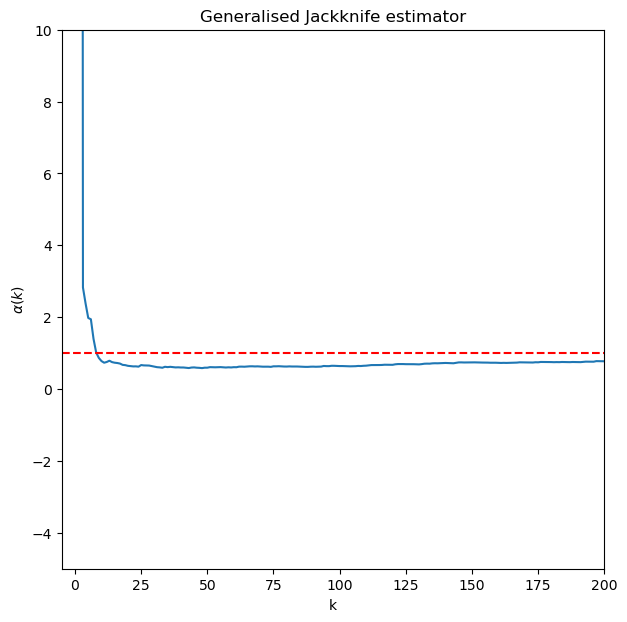

In [536]:
plt.figure(figsize=(7, 7))

plt.plot(np.arange(1, len(gj_alpha1) + 1), gj_alpha1)
plt.axhline(y=1, color='red', linestyle = '--')

plt.title('Generalised Jackknife estimator')
plt.xlabel('k')
plt.ylabel('$\\alpha(k)$')

plt.xlim((-5, 200))
plt.ylim((-5, 10))

plt.show()

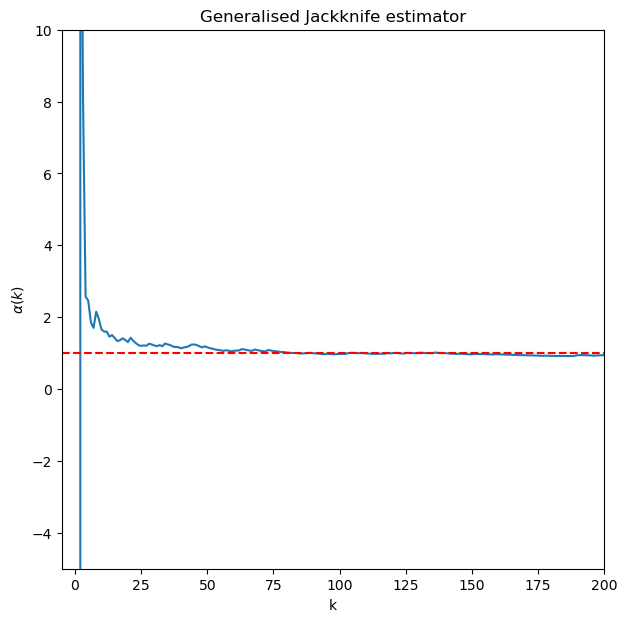

In [537]:
plt.figure(figsize=(7, 7))

plt.plot(np.arange(1, len(gj_alpha2) + 1), gj_alpha2)
plt.axhline(y=1, color='red', linestyle = '--')

plt.title('Generalised Jackknife estimator')
plt.xlabel('k')
plt.ylabel('$\\alpha(k)$')

plt.xlim((-5, 200))
plt.ylim((-5, 10))

plt.show()

In [223]:
sample = frechet_sample(size=1000, gamma=1)

In [224]:
hill_gamma = hill_estimator(sample)
gj_gamma = generalised_jackknife_estimator(sample, hill_gamma)

In [225]:
k_samsee = samsee_tail_size(sample, hill_gamma, gj_gamma)
k_samsee

93

In [226]:
hill_gamma[k_samsee - 1]

1.0124696042449743

In [227]:
gj_gamma[k_samsee - 1]

0.9357099374097966